# Extractive Text Summarization Of Wikipedia Articles

In [1]:
import time

import re

import urllib.request
from bs4 import BeautifulSoup as bs

import string
pm_set = set(list(string.punctuation))

import nltk
from nltk.corpus import stopwords
sw_set = set(stopwords.words("english"))
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from wordcloud import WordCloud
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from sklearn.utils.extmath import randomized_svd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def fetch_wikipedia_article(url="https://en.wikipedia.org/wiki/Nepal"):
    scrapped_data = urllib.request.urlopen(url)
    article = scrapped_data.read()
    parsed_article = bs(article,"lxml")
    paragraphs = parsed_article.find_all("p")
    article_text = ""
    for p in paragraphs:
        article_text += p.text
    return article_text

In [3]:
def preprocess_article(article):
    article_lc = article.lower()#lower case entire article
    article_st = sent_tokenize(article_lc)#convert to sentences
    lmtzr = WordNetLemmatizer()#instantiate lemmatize
    pp_article_st = []
    for sentence in article_st:
        sentence = re.sub(r"[\(.*\)]"," ", sentence)#remove data betweena nd include round backers()
        sentence = re.sub(r"\n","",sentence) #remove "\n" characters
        sentence = re.sub(r"\[\d+\]"," ",sentence)#remove refrences [n]
        sentence = re.sub(r"\[.+\]"," ",sentence) #remove anytig between [] including []
        sentence = re.sub(r"[^a-zA-z0-9]", " ", sentence) #remove any non english characters
        sentence = re.sub(r"\s+"," ",sentence) #remove any whitespaces, tabs, newline charaacters
        sentence = [lmtzr.lemmatize(word) for word in word_tokenize(sentence) if word not in sw_set ]
        sentence = (" ").join(sentence)
        pp_article_st.append(sentence)
    #pp_article_text = (" ").join(pp_article_st)
    return article_st, pp_article_st

In [4]:
article_text = fetch_wikipedia_article("https://en.wikipedia.org/wiki/USA")
article_st, pp_article_st = preprocess_article(article_text)

In [5]:
pp_string = (" ").join(pp_article_st)

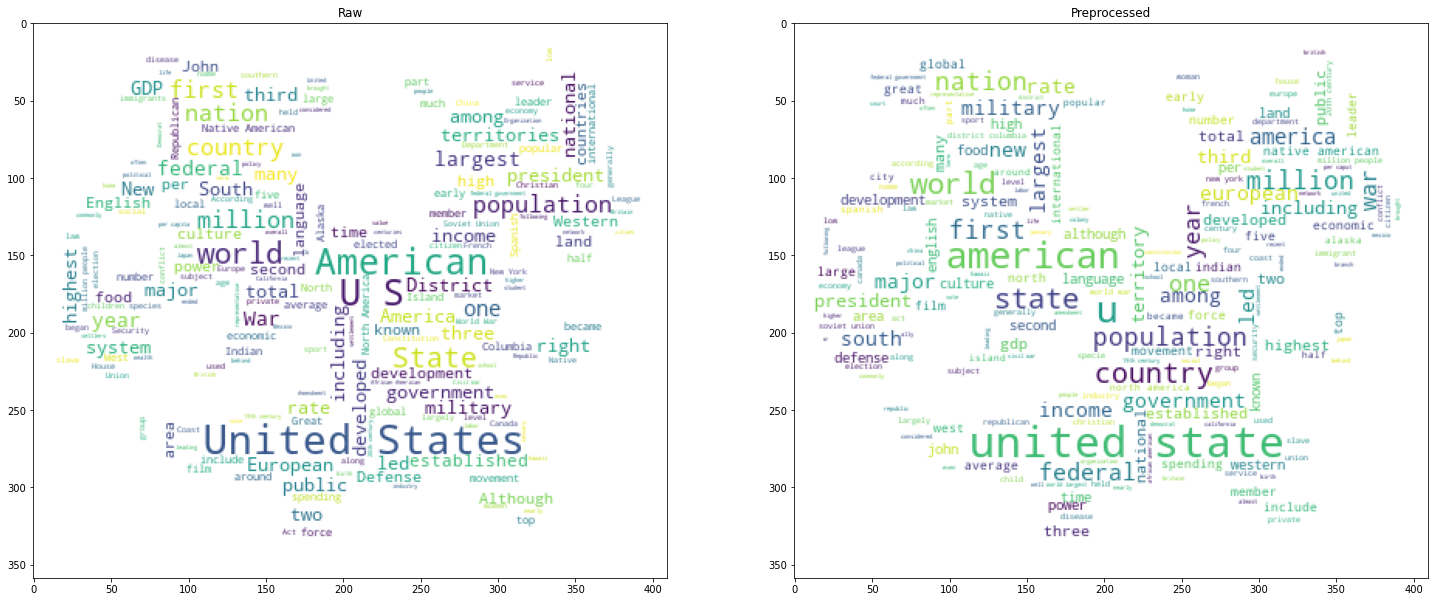

In [6]:
wc_mask = np.array(Image.open(urllib.request.urlopen("http://pm1.narvii.com/5750/abb7fdf1f24f9515a1f1d16e6f05d3f03110c51f_00.jpg")))
wc = WordCloud(background_color="white",mask=wc_mask)
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(wc.generate(article_text))
ax[0].title.set_text("Raw")
ax[1].imshow(wc.generate(pp_string))
ax[1].title.set_text("Preprocessed")
plt.show()

In [7]:
count_vectorizer = CountVectorizer(ngram_range=(3,3)) #1,1(unigrams only)  1,2(unigrams and bigrams) 2,2(bigrams only)

In [8]:
count_vectorizer.fit(pp_article_st)

CountVectorizer(ngram_range=(3, 3))

In [9]:
X = count_vectorizer.transform(pp_article_st)

In [10]:
X.shape

(590, 6848)

In [11]:
N_LINE = 20

In [12]:
U, SIGMA, VT = randomized_svd(X,
                             n_components=N_LINE,
                             n_iter=100,
                             random_state=100)

In [13]:
U.shape #document-topic

(590, 20)

In [14]:
VT.shape #topic-term

(20, 6848)

In [15]:
scores = np.sqrt(np.dot(U**2,SIGMA**2))

In [16]:
scores.shape

(590,)

In [17]:
top_scores_index = np.argsort(scores)

In [18]:
top_scores_index[0:5]

array([589, 189, 313, 396, 285], dtype=int64)

In [19]:
article_array = np.array(article_st)

In [20]:
bow_sum = article_array[top_scores_index[0:N_LINE]]

In [21]:
bow_sum

array(['[523][524]\ninternet sources', 'history.',
       'just over 2% of children are homeschooled.', 'gdp.',
       'population.', 'households.',
       '[32] colloquial names are the "u.s. of a."', 'population.',
       'population.', 'and, internationally, the "states".',
       'most of alaska is subarctic or polar.',
       '[323] it is a member of the g7,[324] g20, and oecd.',
       "[291][292][293] it is the world's oldest surviving federation.",
       'other common forms are the "u.s.", the "usa", and "america".',
       '[108] the u.s. virgin islands were purchased from denmark in 1917.',
       "[385] the u.s. dollar is the world's primary reserve currency.",
       'in addition, there are 1,460 public radio stations.',
       'it described a collection of states—e.g., "the united states are."',
       '[461] whether this perception is accurate has been a topic of debate.',
       '[273] however, the u.s. is a global leader in medical innovation.'],
      dtype='<U456')

In [22]:
bow_sum = list(bow_sum)

In [23]:
bow_sum = (" ").join(bow_sum)

In [24]:
bow_sum

'[523][524]\ninternet sources history. just over 2% of children are homeschooled. gdp. population. households. [32] colloquial names are the "u.s. of a." population. population. and, internationally, the "states". most of alaska is subarctic or polar. [323] it is a member of the g7,[324] g20, and oecd. [291][292][293] it is the world\'s oldest surviving federation. other common forms are the "u.s.", the "usa", and "america". [108] the u.s. virgin islands were purchased from denmark in 1917. [385] the u.s. dollar is the world\'s primary reserve currency. in addition, there are 1,460 public radio stations. it described a collection of states—e.g., "the united states are." [461] whether this perception is accurate has been a topic of debate. [273] however, the u.s. is a global leader in medical innovation.'

In [25]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2)) #1,1(unigrams only)  1,2(unigrams and bigrams) 2,2(bigrams only)
tfidf_vectorizer.fit(pp_article_st)
X = tfidf_vectorizer.transform(pp_article_st)
N_LINE = 20
U, SIGMA, VT = randomized_svd(X,n_components=N_LINE,n_iter=100,random_state=100)
scores = np.sqrt(np.dot(U**2,SIGMA**2))
top_scores_index = np.argsort(scores)
article_array = np.array(article_st)
tfidf_sum = list(article_array[top_scores_index[0:N_LINE]])
tfidf_sum = (" ").join(tfidf_sum)
tfidf_sum

'history. households. population. gdp. population. population. [245] the survey also reported that 22.8% of americans described themselves as agnostic, atheist or simply having no religion—up from 8.2% in 1990. the most harmful risk factors were poor diet, tobacco smoking, obesity, high blood pressure, high blood sugar, physical inactivity, and alcohol use. after a surge in female labor participation, especially in the 1970s, by 1985, the majority of women aged 16 and over were employed. [105] mainland expansion also included the purchase of alaska from russia in 1867. two other amendments were also ratified, ensuring citizenship for blacks and, at least in theory, voting rights for them as well. aaron copland and george gershwin developed a new synthesis of popular and classical music. just over 2% of children are homeschooled. [404] the latter led to emergence of the worldwide entertainment industry. [461] whether this perception is accurate has been a topic of debate. [374] about 9%

In [26]:
from rouge_score import rouge_scorer

In [27]:
scorer = rouge_scorer.RougeScorer(['rouge3', 'rougeL'], use_stemmer=False)

In [28]:
scorer.score(bow_sum,pp_string)

{'rouge3': Score(precision=0.0004729809625162587, recall=0.028985507246376812, fmeasure=0.0009307737056428156),
 'rougeL': Score(precision=0.004255822201205816, recall=0.2571428571428571, fmeasure=0.00837306663565531)}

In [29]:
scorer.score(tfidf_sum,pp_string)

{'rouge3': Score(precision=0.0041385834220172635, recall=0.13725490196078433, fmeasure=0.008034894398530761),
 'rougeL': Score(precision=0.007802340702210663, recall=0.25680933852140075, fmeasure=0.015144561725562186)}